# Sentiment Analysis
## Background Reading:

*Intro to Statistical Learning*: 10.4 Document Classification, 10.5 Recurrent Neural Network (Page 419-431)

*Ethical Algorithm*: Chapter 5, Risky Business (Page 178-188)

## Essence of Data

In [1]:
#install transformers
!pip install  transformers 

#install umap
!pip install umap-learn


In [6]:
!git clone https://github.com/zlisto/sentiment_analysis

'git' is not recognized as an internal or external command,
operable program or batch file.


In [3]:


import os
os.chdir("sentiment_analysis")

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'sentiment_analysis'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import codecs
import umap
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"device ={device}")

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")


In [6]:
def sentiment_classifier(text,model,tokenizer):
    inputs = tokenizer.encode_plus(text, return_tensors='pt', add_special_tokens=True)

    token_type_ids = inputs['token_type_ids']
    input_ids = inputs['input_ids']

    output = model(input_ids, token_type_ids=token_type_ids,return_dict=True,output_hidden_states=True)
    logits = np.array(output.logits.tolist()[0])
    prob = np.exp(logits)/np.sum(np.exp(logits))
    sentiment = np.sum([(x+1)*prob[x] for x in range(len(prob))])  #use this line if you want the mean score
    embedding = output.hidden_states[12].detach().numpy().squeeze()[0]
    
    return sentiment, embedding


In [ ]:
Text = ["This class is kinda boring, but informative", 
        "This class is awesome", 
        "this class is ok", 
        "this class is stupid",
        "this class is fun",
       "this class is fun!",
       "this class is :(",
       "this class is :)",
]

In [ ]:
for text in Text:
    sentiment,embedding = sentiment_classifier(text,model,tokenizer)
    print(f"Text: {text}\nSentiment:{sentiment:.2f}\n")

Text: This class is kinda boring, but informative
Sentiment:3.12

Text: This class is awesome
Sentiment:4.84

Text: this class is ok
Sentiment:3.27

Text: this class is stupid
Sentiment:1.24

Text: this class is fun
Sentiment:4.26

Text: this class is fun!
Sentiment:4.44

Text: this class is :(
Sentiment:3.57

Text: this class is :)
Sentiment:4.29



In [9]:
df = pd.read_csv("data/tweets_sentiment_embedding.csv")

df = df[['screen_name','text','retweet_count']]
ntweets = len(df)
print(f"dataframe has {ntweets} tweets\n")
[print(f"Tweets from {x}") for x in df.screen_name.unique()];


dataframe has 29056 tweets

Tweets from elonmusk
Tweets from MichelleObama
Tweets from BarackObama
Tweets from AOC
Tweets from KingJames
Tweets from KimKardashian
Tweets from mtgreenee
Tweets from nytimes
Tweets from kanyewest
Tweets from JoeBiden


In [ ]:
%%time
c = 0
Sentiment = []
Embedding = []
for index,row in df.iterrows():
    c+=1
    if c%1000==0:print(f"Tweet {c}/{len(df)}")
    sentiment,embedding = sentiment_classifier(row.text,model,tokenizer)
    Sentiment.append(sentiment)
    Embedding.append(embedding)

df['sentiment'] = Sentiment
df.to_csv("data/tweets_sentiment.csv")
df.head()
    

Tweet 1000/29056
Tweet 2000/29056
Tweet 3000/29056
Tweet 4000/29056
Tweet 5000/29056
Tweet 6000/29056
Tweet 7000/29056
Tweet 8000/29056
Tweet 9000/29056
Tweet 10000/29056
Tweet 11000/29056
Tweet 12000/29056
Tweet 13000/29056
Tweet 14000/29056
Tweet 15000/29056
Tweet 16000/29056
Tweet 17000/29056
Tweet 18000/29056
Tweet 19000/29056


In [ ]:
df = pd.read_csv("data/tweets_sentiment_embedding.csv")

print(f"dataframe has {len(df)} tweets")
[print(f"Tweets from {x}") for x in df.screen_name.unique()];
df.sample(n=5)

In [ ]:
fig = plt.figure(figsize = (16,6))
sns.barplot(data = df, y= 'sentiment', x = 'screen_name' )
plt.ylim([2,4])
plt.ylabel("Mean sentiment",fontsize = 16)
plt.grid()
plt.ylim([0,5]);
plt.show()

In [ ]:
for screen_name in df.screen_name.unique():
  sns.histplot(data = df[df.screen_name==screen_name], x = 'sentiment')
  plt.title(f"Tweets of {screen_name}", fontsize = 14)
  plt.show()

In [ ]:
ndisplay = 3
print(f"Top {ndisplay} most postive tweets per screen name")
for screen_name in df.screen_name.unique():
    df_display = df[(df.screen_name==screen_name)].sort_values(by = ['sentiment'], 
                                                               ascending = False)
    c=0
    print(f"\n{screen_name}")
    for index,row in df_display.iterrows():
        c+=1
        text = codecs.decode(row.text, 'unicode_escape')
        print(f"\tsentiment = {row.sentiment:.2f}: {text}")
        if c>=ndisplay:break

print("".join('-' * 200))

print(f"Top {ndisplay} Most Negative Tweets per Screen Name")
for screen_name in df.screen_name.unique():
    df_display = df[(df.screen_name==screen_name)].sort_values(by = ['sentiment'], ascending = True)
    c=0
    print(f"\n{screen_name}")
    for index,row in df_display.iterrows():
        c+=1
        text = codecs.decode(row.text, 'unicode_escape')
        print(f"\tsentiment = {row.sentiment:.2f}: {text}")
        if c>=ndisplay:break



In [ ]:
df['star'] = df.sentiment.round()

fig = plt.figure(figsize = (12,8))
sns.boxplot(data=df, x="star", y="retweet_count")
ymax = df.retweet_count.quantile(0.95)
plt.ylim([0,ymax])
plt.xlabel("Sentiment", fontsize = 16)
plt.ylabel("Retweet Count", fontsize = 16)
plt.grid()
plt.show()

In [ ]:
for screen_name in df.screen_name.unique():
    fig = plt.figure(figsize = (12,8))
    df_plot = df[df.screen_name==screen_name]
    ax = sns.boxplot(data=df_plot, x="star", y="retweet_count")
    ymax = df_plot.retweet_count.quantile(q=0.9)
    plt.ylim([0,ymax])
    plt.xlabel("Sentiment", fontsize = 16)
    plt.ylabel("Retweet Count", fontsize = 16)
    plt.title(f"{screen_name}", fontsize = 16)
    plt.grid()
    plt.show()

In [ ]:
for screen_name in df.screen_name.unique():
  fig = plt.figure(figsize = (8,8))
  sns.scatterplot(data=df[df.screen_name == screen_name], 
                  x="umap_transformer_x", 
                  y="umap_transformer_y", 
                  hue="sentiment", 
                  palette="vlag", s=15)
  plt.title(f"UMAP Transformer Embedding for {screen_name}")
  plt.show()


## AI in fabrics of society:
### Turing Test
Can Machines Think like human?

Artificial Intellegence is developing by leaps and bounds, which enables robots to drive the car, transfer the language and predict the future (though not accurate). But can AI think like people? Sometimes when AIs are chatting like a people like what I experienced years ago when I was chatting with Bing (AI of Bing Research Engine):

![](./fig/sentiment/fig1.jpg)
![](./fig/sentiment/fig2.jpg)
![](./fig/sentiment/fig3.jpg)

You may saw some alluring movies with the topic that AI threats human and replace us, becoming the owner of the world. Indeed, such concerns are not surprising in today's era of rapid development of artificial intelligence, which has replaced many jobs, significantly improving efficiency, but there are also potential dangers such as job losses. Consequently, whether AI can replace human beings is a topic that scientists focus on.

This question confused us since AI occured. Alan Turing, a British mathematician and computer pioneer, gradually developed the basic concepts of computer science during his research on how to break German telegraph codes during World War II, and devoted himself to researching artificial intelligence after the war. In his 1950 paper Computing Machinery and Intelligence, he proposed the famous **Turing Test**, which checks whether a machine can display human intelligence by having it talk to a human, and if the human doesn't find out it's a machine, it's a success.

Specifically, the Turing Test is conducted in a room where human judges talk to a real person they cannot see and to a machine, and determine which is a human and which is a machine based on the quality of the conversation. Now the Turing test conversation is usually 5 minutes long, if more than 30% of the judges treat the computer as a human, then the computer is successful. Turing had predicted that a machine would pass the Turing test in 2000 AD. As a result, an AI really passed, only 10 years later.

Wiki: https://en.m.wikipedia.org/wiki/Turing_test

Some competitions including **Loebner Prize** are held to find the most "human" computer/human. AI now becomes more similar to human beings, the competition aims at finding the most human-like one and the development level of AI.

Wiki: https://en.wikipedia.org/wiki/Loebner_Prize

#Sentiment Analysis on Public Domain Novels## 

In this section, I will be doing sentiment analysis on five books publically available from Project Gutenberg: https://www.gutenberg.org/

First, I import the relevant libraries needed to scrape and analyze the text. Then, for each book I want, I use the requests library to pull the full text from the link. Only the number in the link changes between books; the format stays the same otherwise. (Links were found via Google because Project Gutenberg has specific rules about bots accessing their page and will ban you if you break them!). 

I used the sentence tokenizer from the nltk (natural language toolkit) library to split the text into sentences. It has varying levels of success. Then, I used the sentiment classifier from above to get the sentiment of each sentence. It's important to note that there are many non-sentence sentences, such as chapter titles, or the text introducing the book. 

I included code to write each book to a csv file and to read them back in, so that the sentiment classifier doesn't need to be run each time you want to look at the data (it is slow). In a Jupyter Notebook, you can just use pd.read_csv('path\to\file.csv'), but because I was writing this in Google Colab, I had to do things a little bit differently.

Because of encoding issues that occurred when pulling the text from gutenberg.org, I went into each csv and used find and replace to fix the special characters. I think this could have been done in the code using a different encoder (e.g 'latin-1' vs 'utf-8').

After collecting all the data, I analyzed it to compare the sentiments of the five novels and how much I liked each of them. 


In [ ]:
from http import HTTPStatus
import requests
import nltk
nltk.download('punkt')
from nltk.tokenize import *
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#set url of the book in project gutenberg
url = "https://www.gutenberg.org/cache/epub/25344/pg25344.txt"
response = requests.get(url)
assert response.status_code == HTTPStatus.OK
#pull the text from the site
source = response.text
#break text into sentences
tokenized_text=sent_tokenize(source)
i=0
#make a df with each sentence and its sentiment score
Scarlet_df=pd.DataFrame(columns=['Text','Sentiment'])
for sentence in tokenized_text:
  Scarlet_df.loc[i,'Text']=sentence
  if len(sentence)>512:
    Scarlet_df.loc[i,'Sentiment']=sentiment_classifier(sentence[0:511],model,tokenizer)[0]
  else:
   Scarlet_df.loc[i,'Sentiment']=sentiment_classifier(sentence,model,tokenizer)[0]
  if i%200==0:
    print(i)
  i=i+1
Scarlet_df.to_csv('Scarlet.csv')

In [ ]:
#this block takes ~25 minutes to run because the book is so long
url = "https://www.gutenberg.org/cache/epub/98/pg98.txt"
response = requests.get(url)
assert response.status_code == HTTPStatus.OK
source = response.text
tokenized_text=sent_tokenize(source)
i=0
TwoCities_df=pd.DataFrame(columns=['Text','Sentiment'])
for sentence in tokenized_text:
  TwoCities_df.loc[i,'Text']=sentence
  if len(sentence)>512:
    TwoCities_df.loc[i,'Sentiment']=sentiment_classifier(sentence[0:511],model,tokenizer)[0]
  else:
   TwoCities_df.loc[i,'Sentiment']=sentiment_classifier(sentence,model,tokenizer)[0]
  if i%200==0:
    print(i)
  i=i+1
TwoCities_df.to_csv('TwoCities.csv')

In [ ]:
url = "https://www.gutenberg.org/cache/epub/64317/pg64317.txt"
response = requests.get(url)
assert response.status_code == HTTPStatus.OK
source = response.text
tokenized_text=sent_tokenize(source)
i=0
Gatsby_df=pd.DataFrame(columns=['Text','Sentiment'])
for sentence in tokenized_text:
  Gatsby_df.loc[i,'Text']=sentence
  if len(sentence)>512:
    Gatsby_df.loc[i,'Sentiment']=sentiment_classifier(sentence[0:511],model,tokenizer)[0]
  else:
   Gatsby_df.loc[i,'Sentiment']=sentiment_classifier(sentence,model,tokenizer)[0]
  if i%200==0:
    print(i)
  i=i+1
Gatsby_df.to_csv('Gatsby.csv')

In [ ]:
url = "https://www.gutenberg.org/cache/epub/174/pg174.txt"
response = requests.get(url)
assert response.status_code == HTTPStatus.OK
source = response.text
tokenized_text=sent_tokenize(source)
i=0
Dorian_df=pd.DataFrame(columns=['Text','Sentiment'])
for sentence in tokenized_text:
  Dorian_df.loc[i,'Text']=sentence
  if len(sentence)>512:
    Dorian_df.loc[i,'Sentiment']=sentiment_classifier(sentence[0:511],model,tokenizer)[0]
  else:
   Dorian_df.loc[i,'Sentiment']=sentiment_classifier(sentence,model,tokenizer)[0]
  if i%200==0:
    print(i)
  i=i+1
Dorian_df.to_csv('Dorian.csv')

In [ ]:
url = "https://www.gutenberg.org/cache/epub/42324/pg42324.txt"
response = requests.get(url)
assert response.status_code == HTTPStatus.OK
source = response.text
tokenized_text=sent_tokenize(source)
i=0
Frankenstein_df=pd.DataFrame(columns=['Text','Sentiment'])
for sentence in tokenized_text:
  Frankenstein_df.loc[i,'Text']=sentence
  Frankenstein_df.loc[i,'Sentiment']=sentiment_classifier(sentence,model,tokenizer)[0]
  if i%200==0:
    print(i)
  i=i+1
Frankenstein_df.to_csv('Frankenstein.csv')

In [9]:
#run this part if you need to read csv files into colab from your drive (mounts to drive)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
#only run this part if you already created the csvs and stored them elsewhere
df_Frankenstein = pd.read_csv('/content/drive/MyDrive/Data/Frankenstein.csv')
df_Gatsby=pd.read_csv('/content/drive/MyDrive/Data/Gatsby.csv',encoding='latin-1')
df_TwoCities=pd.read_csv('/content/drive/MyDrive/Data/TwoCities.csv')
df_Scarlet=pd.read_csv('/content/drive/MyDrive/Data/Scarlet.csv',encoding='latin-1')
df_Dorian=pd.read_csv('/content/drive/MyDrive/Data/Dorian.csv',encoding='latin-1')

In [37]:
print(df_Frankenstein['Sentiment'].median())
print(df_Dorian['Sentiment'].median())
print(df_Scarlet['Sentiment'].median())
print(df_Gatsby['Sentiment'].median())
print(df_TwoCities['Sentiment'].median())
median_vals=[df['Sentiment'].median() for df in [df_TwoCities,df_Gatsby,df_Scarlet,df_Dorian,df_Frankenstein]]

2.984138690225352
2.796345243
2.961320363
2.7663591715
2.7617838514999997


In the below plot, I ordered the books from my least to most favorite. The coloring has such drastic changes because three of the books have an average sentiment around 2.77, then the remaining two are around 2.97. The color differences reflect this jump. In general, the books I liked more tended to have a slightly higher average sentiment.

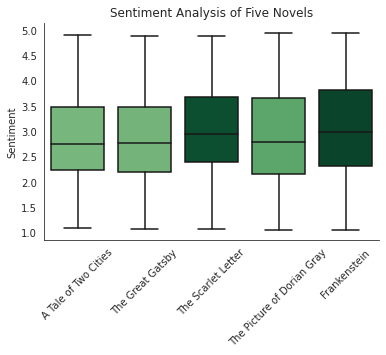

In [ ]:
combined_dfs = pd.DataFrame({'A Tale of Two Cities': df_TwoCities['Sentiment'],
                             'The Great Gatsby': df_Gatsby['Sentiment'],
                             'The Scarlet Letter': df_Scarlet['Sentiment'],
                             'The Picture of Dorian Gray': df_Dorian['Sentiment'],
                             'Frankenstein': df_Frankenstein['Sentiment']})
sns.set_style('white')
# norm = plt.Normalize(min(median_vals), max(median_vals))
norm = plt.Normalize(2.5, 3)
colors = plt.cm.YlGn(norm(median_vals))
sns.boxplot(data=combined_dfs, palette=colors)
sns.despine()
plt.xticks(rotation=45)
plt.ylabel('Sentiment')
plt.title('Sentiment Analysis of Five Novels')
plt.show()

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import codecs
import gensim
import re
import string
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot
from sklearn.manifold import TSNE
from nltk.corpus import stopwords

In [2]:
df_lyrics= pd.read_csv('billboard_lyrics_1964-2015.csv')
df_lyrics.head()

,Rank,Song,Artist,Year,Lyrics,Source
0,1,wooly bully,sam the sham and the pharaohs,1965,sam the sham miscellaneous wooly bully wooly b...,3.0
1,2,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch you know that i love yo...,1.0
2,3,i cant get no satisfaction,the rolling stones,1965,,1.0
3,4,you were on my mind,we five,1965,when i woke up this morning you were on my mi...,1.0
4,5,youve lost that lovin feelin,the righteous brothers,1965,you never close your eyes anymore when i kiss...,1.0


In [3]:
#Choose the lyrics of madonna
df_madonna=df_lyrics[df_lyrics['Artist']=='madonna'].reset_index(drop=True)
df_madonna=df_madonna['Lyrics']
df_madonna=pd.DataFrame(df_madonna)
df_madonna.head()

,Lyrics
0,something in the way you love me wont let me ...
1,you must be my lucky star cause you shine on ...
2,holiday celebrate holiday celebrateif we took...
3,i made it through the wilderness somehow i ma...
4,swaying room as the music starts strangers ma...


In [4]:
df_madonna=df_madonna.dropna(axis=0).reset_index(drop=True)
df_madonna.head()

,Lyrics
0,something in the way you love me wont let me ...
1,you must be my lucky star cause you shine on ...
2,holiday celebrate holiday celebrateif we took...
3,i made it through the wilderness somehow i ma...
4,swaying room as the music starts strangers ma...


In [5]:
list1 = df_madonna['Lyrics']

#Split sentences into words
list2=[]
for w in range(0,len(list1)-1):
    list2.append(list1[w].split())

#Remove brackets from list
list3 = [str(x) for item in list2 for x in item]

In [6]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk import data
stop_words = set(stopwords.words('english'))

#Count word frequency and remove stopwords
fq = pd.Series(list3).value_counts()

for i in stop_words:
    try:  
        fq.pop(i)  
    except:
        continue 
        
print(fq[:20])

love        151
like         88
got          87
know         76
im           73
baby         71
mmm          66
youre        65
never        51
ill          49
true         48
see          47
heart        45
star         43
material     42
feel         41
make         41
gonna        40
let          39
dont         39
dtype: int64


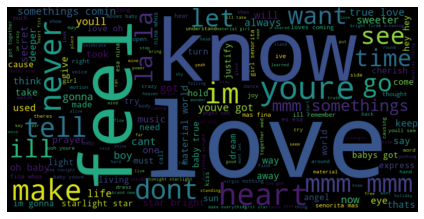

In [7]:
import os
from os import path
from wordcloud import WordCloud
from matplotlib import pyplot as plt

#Convert list to string
listToStr = ' '.join(map(str, list3))

#Generative word cloud
wc = WordCloud(scale=2,max_font_size = 100)
wc.generate_from_text(listToStr)

#Show Image
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.tight_layout()

In [40]:
import PyPDF2
temp = open('Batman Forever.pdf', 'rb')
batman_pdf = PyPDF2.PdfReader(temp)
#make for loop for all pages also remove all the newline characters and extra spaces
batman_pdf
batman_str = batman_pdf.getPage(0).extractText()
for i in range(1, 112):
    batman_str += batman_pdf.getPage(i).extractText()

In [27]:
import nltk

tokenized_text= nltk.sent_tokenize(batman_str)
i=0
batman_df=pd.DataFrame(columns=['Text','Sentiment'])
for sentence in tokenized_text:
  batman_df.loc[i,'Text']=sentence
  batman_df.loc[i,'Sentiment']=sentiment_classifier(sentence,model,tokenizer)[0]
  if i%200==0:
    print(i)
  i=i+1

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200


In [28]:
batman_df['Sentiment'].median()

2.9759801552480707

In [30]:
temp = open('The Princess Bride.pdf', 'rb')
pb_pdf = PyPDF2.PdfReader(temp)
#make for loop for all pages also remove all the newline characters and extra spaces
pb_pdf
pb_str = pb_pdf.getPage(0).extractText()
for i in range(1, 105):
    pb_str += pb_pdf.getPage(i).extractText()

In [31]:
tokenized_text= nltk.sent_tokenize(pb_str)
i=0
pb_df=pd.DataFrame(columns=['Text','Sentiment'])
for sentence in tokenized_text:
  pb_df.loc[i,'Text']=sentence
  pb_df.loc[i,'Sentiment']=sentiment_classifier(sentence,model,tokenizer)[0]
  if i%200==0:
    print(i)
  i=i+1

0
200
400
600
800
1000
1200
1400
1600
1800
2000


In [32]:
pb_df['Sentiment'].median()

2.9282034762872806

In [ ]:
#There does not seem to be much difference between the Sentiment of the highest rated comedy (The Princess Bride) and the lowest rated comedy (Batman Forever). They both have sentimenst around 2.9